In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from holotomocupy.magnification import M
from holotomocupy.shift import S, ST, registration_shift
from holotomocupy.proc import remove_outliers
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.utils import *

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [5]:
n = 2048
ntheta = 1

# ID16B setup
ndist = 4

energy = 29.63  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
detector_pixelsize= 0.65e-6
focusToDetectorDistance = 0.704433  # [m]
sx0h = 0.8525605999567023e-3; #1.077165773192669 for 75nm.
sx0v = 0.80170811624758109e-3; #1.110243284221266 for 75nm.
sx0 = 0.5*(sx0h+sx0v)
z1 = np.array([54.9598e-3, 55.96e-3, 59.1701e-3, 69.17e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
print(f"{voxelsize=}")
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8

voxelsize=0.05071294218186826


In [24]:
data0 = np.zeros([ntheta,ndist,n,n],dtype='float32')
ref0 = np.zeros([1,ndist,n,n],dtype='float32')
dark0 = np.zeros([1,n,n],dtype='float32')
cropx_left=cropx_right=cropy_up=cropy_down=0
binning = 0
# theta = np.loadtxt(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_/angles_file.txt').astype('float32')[:][:900:900//ntheta]
# print(f'{theta=}')
for k in range(ndist):
    for j in range(0,ntheta):
        # print(j)
        jtheta=j*900//ntheta
        fname = f'/data/vnikitin/ESRF/ID16B/009/033_009_50nm_{k+1}_/033_009_50nm_{k+1}_{jtheta:04}.edf'
        tmp = dxchange.read_edf(fname)[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
        for kb in range(binning):
            tmp = (tmp[::2]+tmp[1::2])/2
            tmp = (tmp[:,::2]+tmp[:,1::2])/2
        data0[j,k] = tmp

    tmp = dxchange.read_edf(f'/data/vnikitin/ESRF/ID16B/009/033_009_50nm_{k+1}_/refHST0000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref0[:,k] = tmp

tmp = dxchange.read_edf(f'/data/vnikitin/ESRF/ID16B/009/033_009_50nm_1_/dark.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
for kb in range(binning):
    tmp = (tmp[::2]+tmp[1::2])/2
    tmp = (tmp[:,::2]+tmp[:,1::2])/2
dark0[:] = tmp

# data0-=dark0
# ref0 -= dark0
# mean_all = np.mean(data0[:,:,0:n//16,0:n//16])

# mean_each = np.mean(data0[:,:,0:n//16,0:n//16],axis=(2,3))
# data0 = data0*mean_all/mean_each[:,:,np.newaxis,np.newaxis]

# ref0_mean = np.mean(ref0[:,0:n//16,0:n//16],axis=(1,2))
# ref0 = ref0*mean_all/ref0_mean[:,np.newaxis,np.newaxis]

(1, 4, 2048, 2048) (1, 4, 2048, 2048)


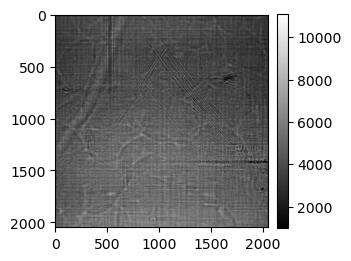

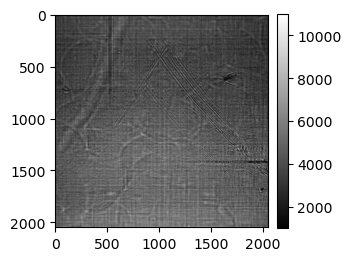

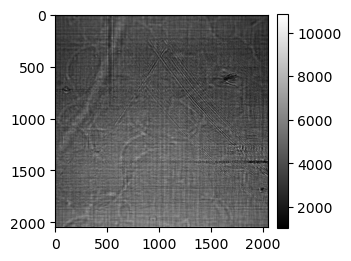

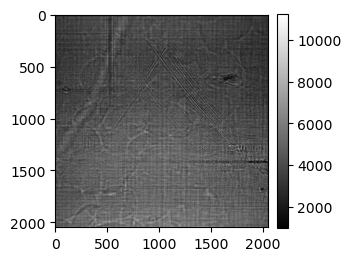

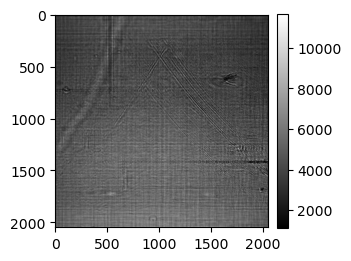

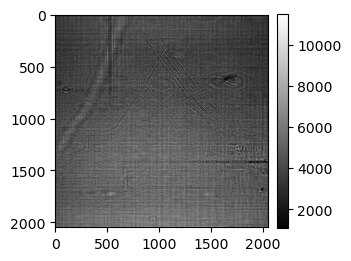

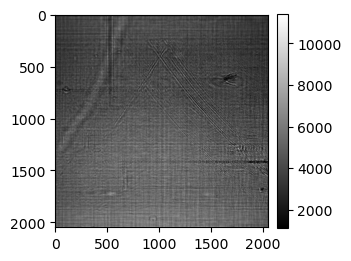

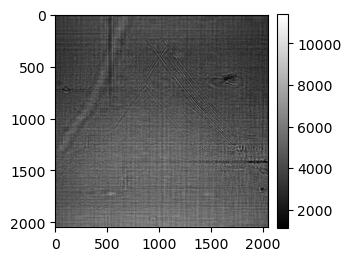

In [25]:
print(data0.shape,ref0.shape)
# remove outliers
# for k in range(ndist):
#     radius = 7
#     threshold = 20000
#     data0[:,k] = remove_outliers(data0[:,k], radius, threshold)
#     ref0[:,k] = remove_outliers(ref0[:,k], radius, threshold)        

for k in range(ndist):
    mshow(data0[0,k])
for k in range(ndist):
    mshow(ref0[0,k])

## Take mean for flat and dark

In [26]:
ref0 = np.mean(ref0,axis=0)[np.newaxis]
dark0 = np.mean(dark0,axis=0)[np.newaxis]

### Normalize everything wrt to the mean of the reference image

In [27]:
mean_value = np.mean(ref0)
dark00 = dark0.astype('float32')/mean_value
ref00 = ref0.astype('float32')/mean_value
data00 = data0.astype('float32')/mean_value


data00 = data00-np.mean(dark00,axis=0)
ref00 = ref00-np.mean(dark00,axis=0)

data00[data00<0] = 0
ref00[ref00<0] = 0

# Find shifts of reference images

In [28]:
shifts_ref0 = np.zeros([1, ndist, 2], dtype='float32')
for k in range(ndist):
    shifts_ref0[:, k] = registration_shift(ref00[:, k], ref00[:, 0], upsample_factor=1000)
print(f'Found shifts: \n{shifts_ref0=}')

shifts_ref = np.zeros([ntheta, ndist, 2], dtype='float32')
for k in range(ndist):
    im = np.tile(ref00[0, 0], [ntheta, 1, 1])
    shifts_ref[:, k] = registration_shift(data00[:, k], im, upsample_factor=1000)  
print(f'Found shifts: \n{shifts_ref=}')


Found shifts: 
shifts_ref0=array([[[ 0.   ,  0.   ],
        [-0.076,  0.005],
        [-0.187, -0.024],
        [-0.294, -0.073]]], dtype=float32)
Found shifts: 
shifts_ref=array([[[-0.032, -0.052],
        [-0.129, -0.106],
        [-0.224, -0.073],
        [-0.337, -0.088]]], dtype=float32)


### Assuming the shifts are calculated, shifts refs back

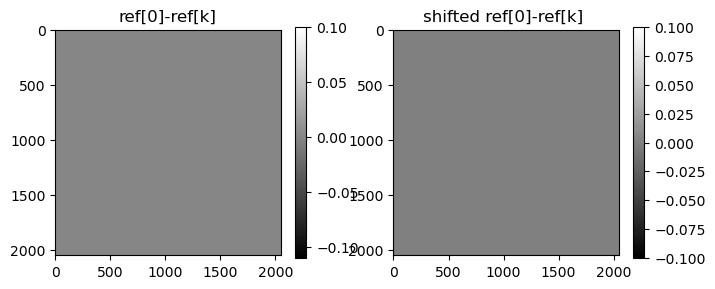

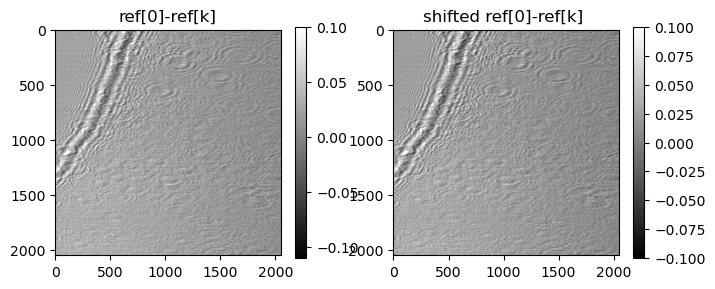

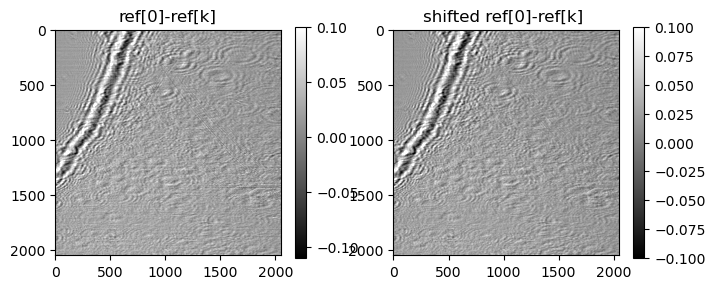

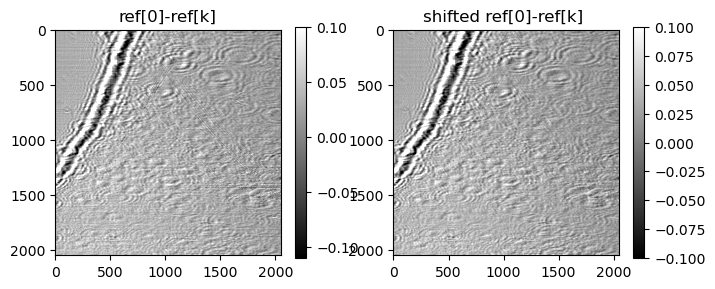

In [30]:
data0 = data00.copy()
ref0 = ref00.copy()
# shifted refs for correction
for k in range(ndist):
    # shift refs back
    ref0[:, k] = ST(ref0[:, k].astype('complex64'), shifts_ref0[:, k]).real

ref0c = np.tile(np.array(ref0), (ntheta, 1, 1, 1))
for k in range(ndist):
    # shift refs the position where they were when collecting data
    ref0c[:, k] = S(ref0c[:, k].astype('complex64'), shifts_ref[:, k]).real

for k in range(ndist):    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im = axs[0].imshow(ref00[0, 0]-ref00[0, k], cmap='gray',vmax=.1,vmin=-.11)
    axs[0].set_title('ref[0]-ref[k]')
    fig.colorbar(im)
    # ,vmin=-500,vmax=500)
    im = axs[1].imshow(ref0[0, 0]-ref0[0, k], cmap='gray',vmax=.1,vmin=-.1)
    axs[1].set_title('shifted ref[0]-ref[k] ')
    fig.colorbar(im)

### divide data by the reference image

In [31]:
rdata = data0/(ref0+1e-9)

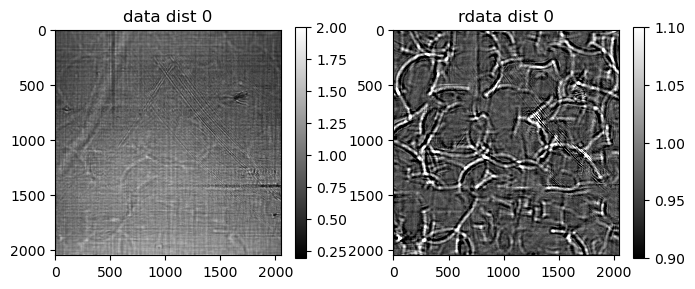

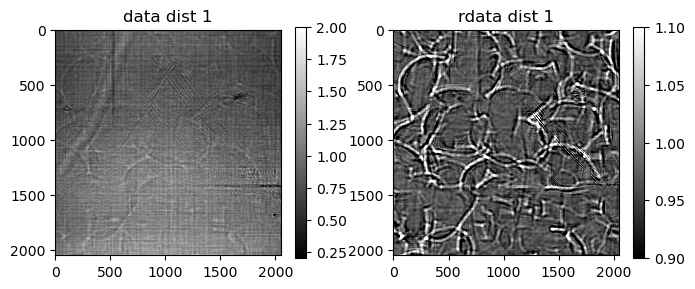

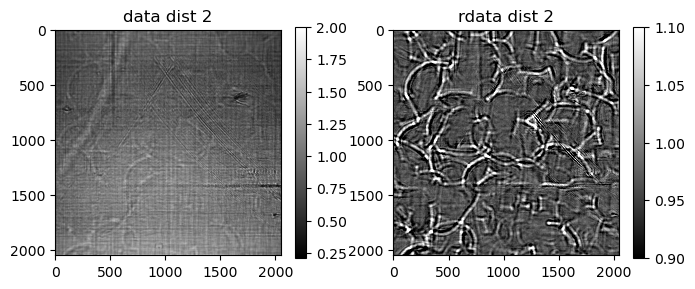

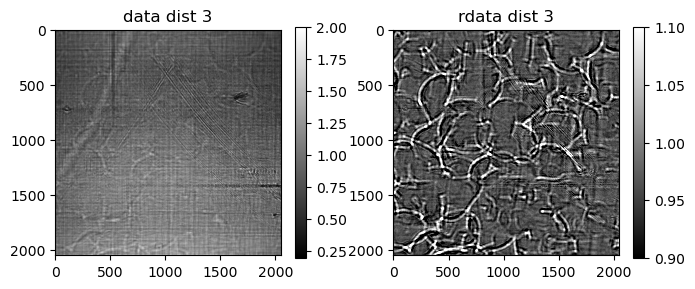

In [32]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im=axs[0].imshow(data0[0,k],cmap='gray',vmax=2)
    axs[0].set_title(f'data dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata[0,k],cmap='gray',vmax=1.1,vmin=0.9)
    axs[1].set_title(f'rdata dist {k}')
    fig.colorbar(im)

### Scale images

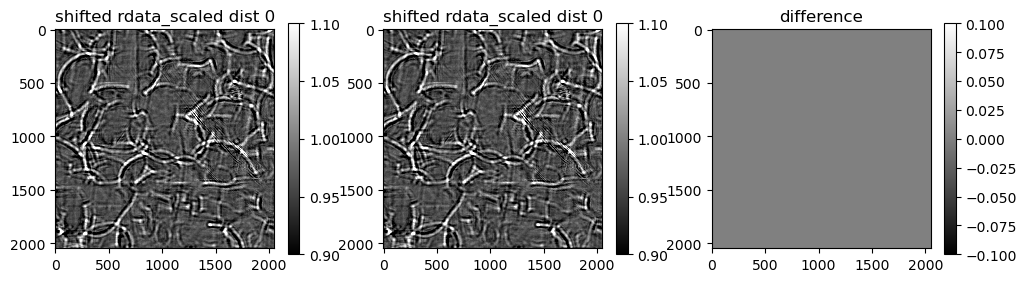

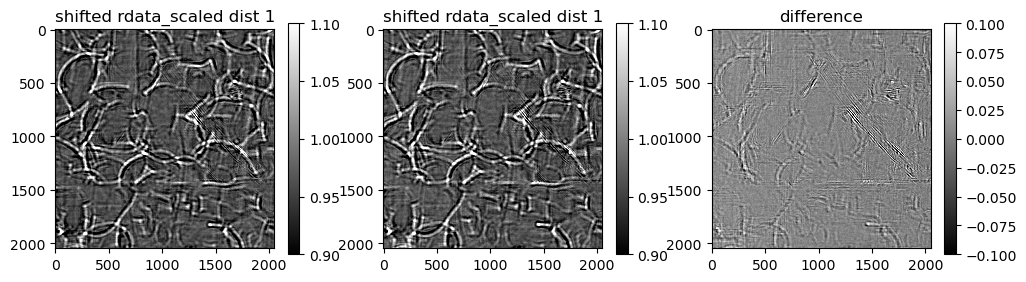

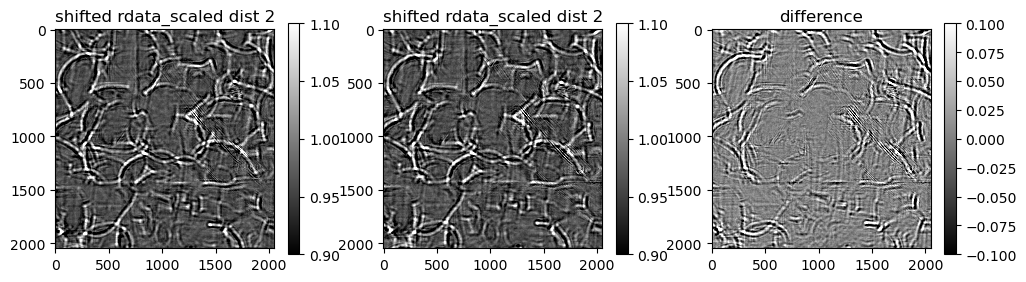

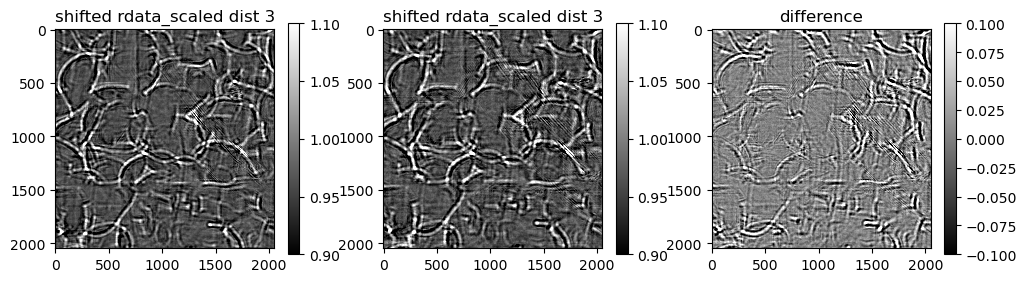

In [33]:
rdata_scaled = rdata.copy()

for k in range(ndist):
    rdata_scaled[:, k] = M(rdata_scaled[:, k], 1/norm_magnifications[k], n).real

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    im = axs[0].imshow(rdata_scaled[0, 0], cmap='gray', vmin=0.9, vmax=1.1)
    axs[0].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled[0, k], cmap='gray', vmin=0.9, vmax=1.1)
    axs[1].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled[0, k]-rdata_scaled[0, 0], cmap='gray', vmin=-0.1, vmax=0.1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

### Align images between different planes


#### Approach 1. Align data

In [11]:
# shifts_drift = np.zeros([ntheta,ndist,2],dtype='float32')

# for k in range(1,ndist):
#     shifts_drift[:,k] = registration_shift(rdata_scaled[:,k],rdata_scaled[:,0],upsample_factor=1000)

# # note shifts_drift should be after magnification.
# shifts_drift*=norm_magnifications[np.newaxis,:,np.newaxis]

# shifts_drift_median = shifts_drift.copy()
# shifts_drift_median[:] = np.median(shifts_drift,axis=0)

# print(shifts_drift_median[0],shifts_drift_init[0])
# for k in range(ndist):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 3))
#     im=axs[0].plot(shifts_drift[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_median[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_init[:,k,0],'r.')
#     axs[0].set_title(f'distance {k}, shifts y')
#     im=axs[1].plot(shifts_drift[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_median[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_init[:,k,1],'r.')
#     axs[1].set_title(f'distance {k}, shifts x')
#     # plt.show()

#### Approach 2. Align CTF reconstructions from 1 distance

[0.05067184 0.05151455 0.0542     0.06237803] 0.05071294218186826


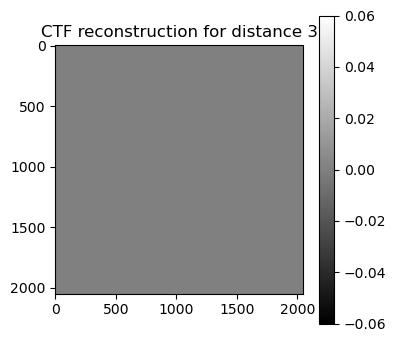

Found shifts: 
shifts_drift=array([[[   0.     ,    0.     ],
        [ 318.14514, -585.3317 ],
        [-495.95633,  682.7589 ],
        [ 742.04315, -599.01654]]], dtype=float32)


In [37]:
recCTF_1dist = np.zeros([ntheta, ndist, n, n], dtype='float32')
distances_ctf = (distances/norm_magnifications**2)[:ndist]
print(distances_ctf,voxelsize)
for k in range(ndist):
    recCTF_1dist[:, k] = CTFPurePhase(
        rdata_scaled[:, k:k+1], distances_ctf[k:k+1], wavelength, voxelsize, 1e-1)

plt.figure(figsize=(4, 4))
plt.title(f'CTF reconstruction for distance {ndist-1}')
plt.imshow(recCTF_1dist[0, -1], cmap='gray',vmax=0.06,vmin=-0.06)
plt.colorbar()
plt.show()

shifts_drift = np.zeros([ntheta, ndist, 2], dtype='float32')

for k in range(1, ndist):
    shifts_drift[:, k] = registration_shift(
        recCTF_1dist[:, k], recCTF_1dist[:, 0], upsample_factor=1000)

# note shifts_drift should be after magnification.
shifts_drift *= norm_magnifications[np.newaxis, :, np.newaxis]

    
print(f'Found shifts: \n{shifts_drift=}')


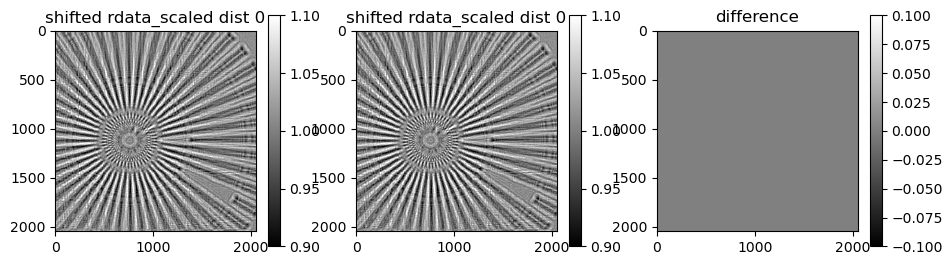

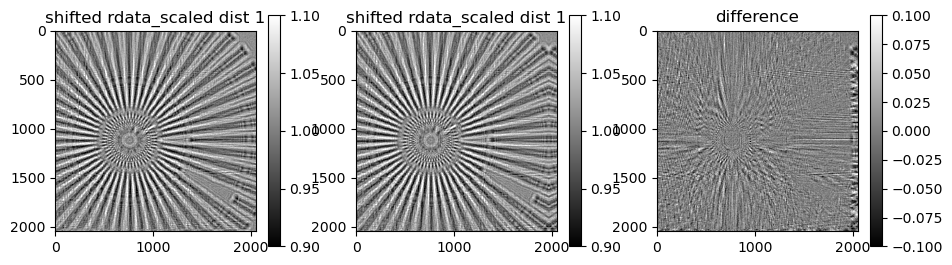

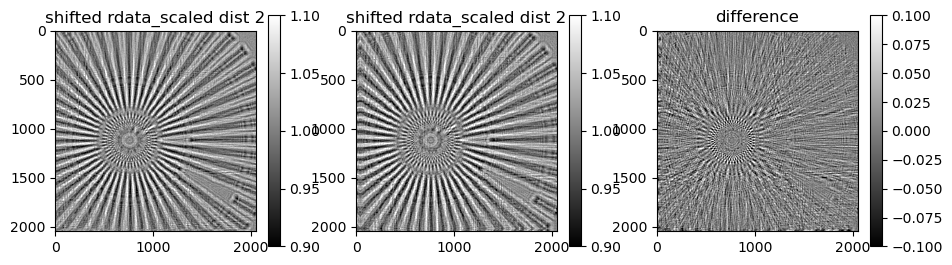

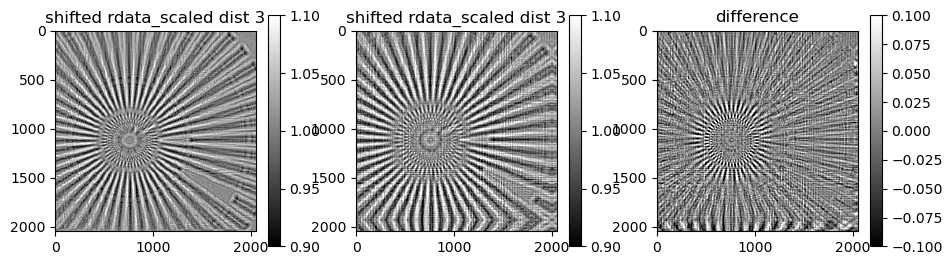

In [13]:
rdata_scaled_aligned = rdata_scaled.copy()
for k in range(ndist):
    rdata_scaled_aligned[:, k] = ST(rdata_scaled[:, k], shifts_drift[:, k]/norm_magnifications[k]).real
    
for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))
    im = axs[0].imshow(rdata_scaled_aligned[0, 0], cmap='gray', vmin=.9, vmax=1.1)
    axs[0].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled_aligned[0, k], cmap='gray', vmin=.9, vmax=1.1)
    axs[1].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled_aligned[0, k] - rdata_scaled_aligned[0, 0], cmap='gray', vmin=-0.1, vmax=.1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

#### Reconstruction by the MultiPaganin method

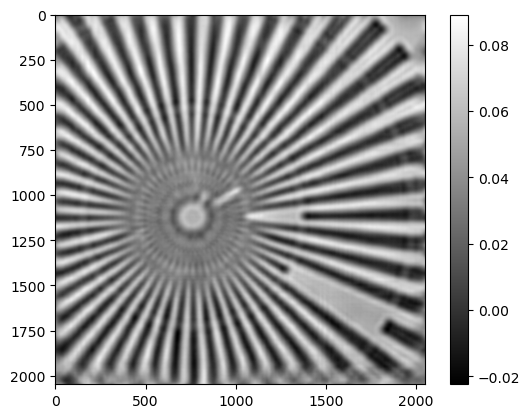

In [14]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:ndist]
recMultiPaganin = multiPaganin(rdata_scaled_aligned, distances_pag, wavelength, voxelsize, 10, 1e-12)
plt.imshow(recMultiPaganin[0],cmap='gray')
plt.colorbar()

#### Reconstruction by the CTF pure phase method

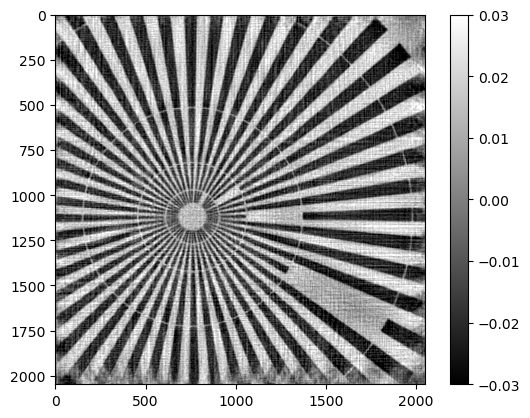

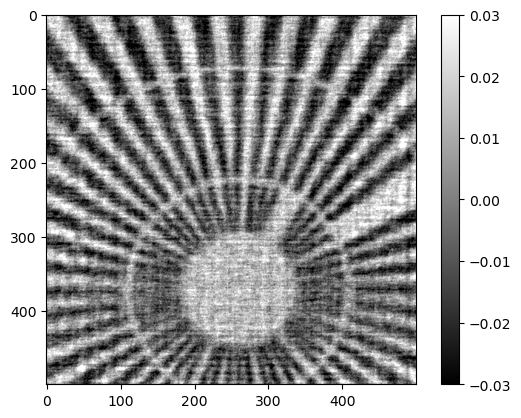

In [15]:
distances_ctf = (distances/norm_magnifications**2)[:ndist]

recCTF = CTFPurePhase(rdata_scaled_aligned, distances_ctf, wavelength, voxelsize, 1e-2)
plt.imshow(recCTF[0],cmap='gray',vmax=0.03,vmin=-0.03)
plt.colorbar()
plt.show()
plt.imshow(recCTF[0,750:750+500,500:1000],cmap='gray',vmax=0.03,vmin=-0.03)
plt.colorbar()
plt.show()